# Modelowanie ARIMA - case study

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.graphics.api import qqplot
%matplotlib inline
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller
def check_time_series_stationary(y, rolling_len = 12):
    
    y = pd.Series(y)
    
    df_test = adfuller(y)
    
    if df_test[1] < 0.05:
        print('Szereg jest stacjonarny')
    else:
        print('Szereg jest niestacjonarny')
    
    print("{0:^32s}".format("Dickey-Fuller Test"))
    print("-"*32+"\n")
    
    print("{0:<20s}: {1:>10.4f}".format('Test Statistic', df_test[0]))
    print("{0:<20s}: {1:>10.4f}".format('p-value', df_test[1]))
    print("-"*32+"\n")
    
    rolling_mean = y.rolling(rolling_len).mean()
    rolling_var = y.rolling(rolling_len).var()

    plt.plot(y)
    plt.plot(rolling_mean, label="Rolling mean")
    plt.plot(rolling_var, label="Rolling var")
    plt.legend()
    plt.show()
    
    print("{0:^32s}".format("Autocorrelation plot"))
    print("-"*32+"\n")
    pd.plotting.autocorrelation_plot(y)
    plt.show()

# Zadanie - case study

Dokonaj analizy szeregu czasowego `AirPassengers`. 

a) Przekształć szereg do postaci stacjonarnej.

b) Dopasuj odpowiedni model za pomocą kroswalidacji dla szeregów czasowych.

c) Dokonaj predykcji na zbiorze testowym przy użyciu modelu zbudowanego na zbiorze treningowym.

Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :     0.8154
p-value             :     0.9919
--------------------------------



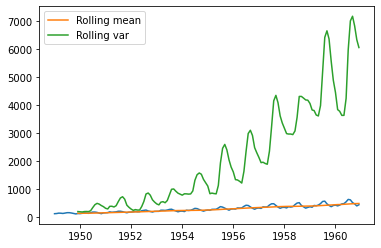

      Autocorrelation plot      
--------------------------------



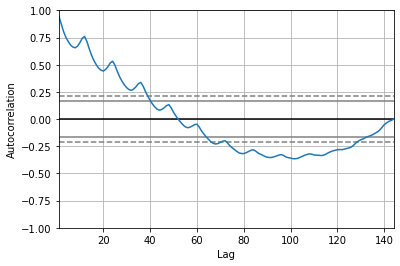

In [4]:
air_passengers = pd.read_csv('AirPassengers.csv', 
                 parse_dates=['Month'], index_col='Month')

check_time_series_stationary(air_passengers['#Passengers'])
#brak stacjonarności, najpierw poradzimy sobie z nierówną wariancją

Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -1.7170
p-value             :     0.4224
--------------------------------



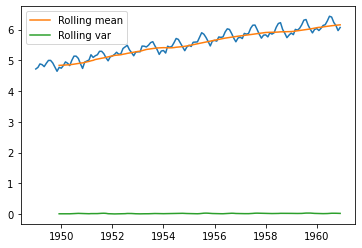

      Autocorrelation plot      
--------------------------------



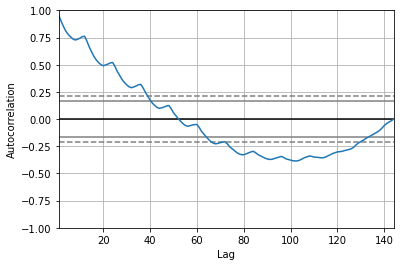

In [5]:
# przekształcenie logarytmiczne
air_passengers_log = np.log(air_passengers)
check_time_series_stationary(air_passengers_log['#Passengers'])
# mamy trend i sezonowość, pozbądźmy się trendu

Szereg jest niestacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -2.7171
p-value             :     0.0711
--------------------------------



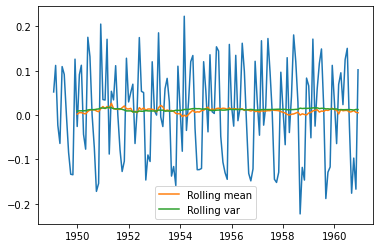

      Autocorrelation plot      
--------------------------------



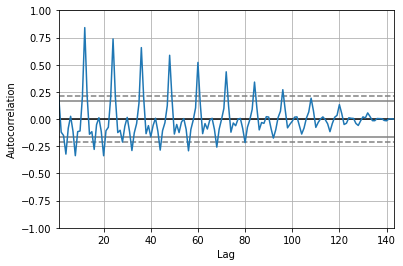

In [6]:
#pozbywamy się trendu
air_passengers_log_diff = air_passengers_log.diff(1).dropna()
check_time_series_stationary(air_passengers_log_diff['#Passengers'])
#jeszcze sezon 

Szereg jest stacjonarny
       Dickey-Fuller Test       
--------------------------------

Test Statistic      :    -4.4433
p-value             :     0.0002
--------------------------------



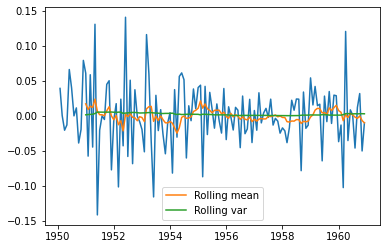

      Autocorrelation plot      
--------------------------------



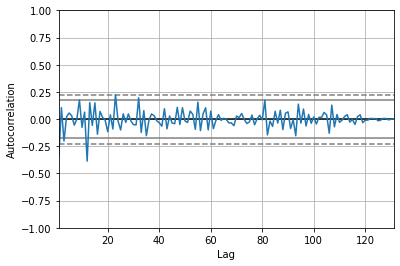

In [7]:
#różnicujemy o 12 celem pozbysia się sezonowości
air_passengers_log_diff_12 = air_passengers_log_diff.diff(12).dropna()
check_time_series_stationary(air_passengers_log_diff_12['#Passengers'])
#stacjonarny

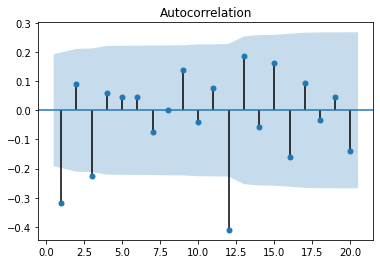

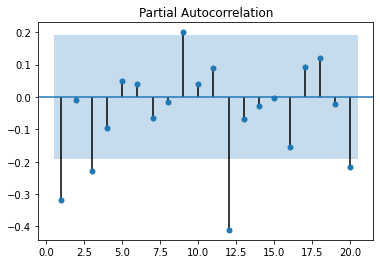

In [8]:
#na razie zobaczmy jaki model dla szeregu stacjonarnego wziąć
k = int(air_passengers_log_diff_12.size * 0.8)

air_passengers_log_diff_12_train = air_passengers_log_diff_12[:k]
air_passengers_log_diff_12_test = air_passengers_log_diff_12[k:]

plot_acf(air_passengers_log_diff_12_train ,lags = 20,zero = False)
plot_pacf(air_passengers_log_diff_12_train ,lags = 20,zero = False)
plt.show() #ARMA(3,3)?

In [9]:
#teraz użyjemy funkcji do kroswalidacyjnego (w sensie szeregów czasowych) znalezienia odpowiedniego modelu
def mse(y, yhat):
    return np.mean((y - yhat) ** 2)

def mae(y, yhat):
    return np.median(np.abs(y - yhat))


def find_the_best_arma_crossal(ts, max_p = 10, max_q=10, ar = False, cross=5):
    tscv = TimeSeriesSplit(n_splits=cross)
    
    aic = np.zeros((max_p + 1, max_q + 1))
    bic = np.zeros((max_p + 1, max_q + 1))
    mae_values = np.zeros((max_p + 1, max_q + 1))
    mse_values = np.zeros((max_p + 1, max_q + 1))
    
    for i in range(max_p + 1):
        for j in range(max_q + 1):
            if (i == j == 0):
                aic[0, 0] = bic[0, 0] = mae_values[0, 0] = mse_values[0, 0] = np.Inf
            elif (i == 0) | ((not ar) & (j == 0)):
                aic[i, j] = bic[i, j] = mae_values[i, j] = mse_values[i, j] = np.Inf
            else:
                aic_cross, bic_cross, mse_cross, mae_cross = [], [], [], []
                for train_index, test_index in tscv.split(ts.values):
                    train, test = ts.iloc[train_index], ts.iloc[test_index]
                    try:
                      arma = ARIMA(train, order=(i, 0, j)).fit()
                      aic_cross.append(arma.aic)
                      bic_cross.append(arma.bic)
                      pred = arma.predict(start=str(np.min(test.index).year), end=str(np.max(test.index).year), dynamic=True)
                      mse_cross.append(mse(test.values, pred.values))
                      mae_cross.append(mae(test.values, pred.values))
                    except:
                      next
                aic[i, j] = np.mean(aic_cross)
                bic[i, j] = np.mean(arma.bic)
                mae_values[i, j] = np.nanmean(mae_cross)
                mse_values[i, j] = np.nanmean(mse_cross)
                print("ARMA(%d, %d): AIC=%f; BIC=%f; MSE=%f; MAE=%f" % (i, j, arma.aic, arma.bic, 
                                                                        mse_values[i, j], mae_values[i, j]))

    print("-" * 30)
    min_aic = np.nanmin(aic)
    min_arg_aic = np.argwhere(aic == min_aic)[0] 
    print("MINIMUM AIC=%f for p=%d, q=%d" % (min_aic, min_arg_aic[0], min_arg_aic[1]))
    
    min_bic = np.nanmin(bic)
    min_arg_bic = np.argwhere(bic == min_bic)[0] 
    print("MINIMUM BIC=%f for p=%d, q=%d" % (min_bic, min_arg_bic[0], min_arg_bic[1]))
    
    min_mse = np.nanmin(mse_values)
    min_arg_mse = np.argwhere(mse_values == min_mse)[0]
    print("MINIMUM MSE=%f for p=%d, q=%d" % (min_mse, min_arg_mse[0], min_arg_mse[1]))
    
    min_mae = np.nanmin(mae_values)
    min_arg_mae = np.argwhere(mae_values == min_mae)[0]
    print("MINIMUM MAE=%f for p=%d, q=%d" % (min_mae, min_arg_mae[0], min_arg_mae[1]))

In [10]:
find_the_best_arma_crossal(air_passengers_log_diff_12_train, 5, 5,ar = True, cross=5)

ARMA(1, 0): AIC=-280.947401; BIC=-273.549677; MSE=0.001893; MAE=0.029077
ARMA(1, 1): AIC=-280.346970; BIC=-270.483337; MSE=0.001905; MAE=0.028323
ARMA(1, 2): AIC=-278.641739; BIC=-266.312199; MSE=0.001908; MAE=0.028541
ARMA(1, 3): AIC=-279.980794; BIC=-265.185346; MSE=0.001916; MAE=0.028244
ARMA(1, 4): AIC=-279.762890; BIC=-262.501533; MSE=0.002007; MAE=0.028562
ARMA(1, 5): AIC=-278.040042; BIC=-258.312777; MSE=0.001571; MAE=0.026818
ARMA(2, 0): AIC=-278.984200; BIC=-269.120568; MSE=0.001892; MAE=0.029055
ARMA(2, 1): AIC=-281.450853; BIC=-269.121313; MSE=0.001905; MAE=0.028464
ARMA(2, 2): AIC=-278.604949; BIC=-263.809501; MSE=0.001911; MAE=0.028483
ARMA(2, 3): AIC=-278.544001; BIC=-261.282645; MSE=0.001944; MAE=0.028584
ARMA(2, 4): AIC=-277.425749; BIC=-257.698484; MSE=0.001969; MAE=0.029031
ARMA(2, 5): AIC=-276.259831; BIC=-254.066658; MSE=0.001565; MAE=0.027025
ARMA(3, 0): AIC=-282.165937; BIC=-269.836396; MSE=0.001923; MAE=0.028443
ARMA(3, 1): AIC=-280.647890; BIC=-265.852442; MSE=0

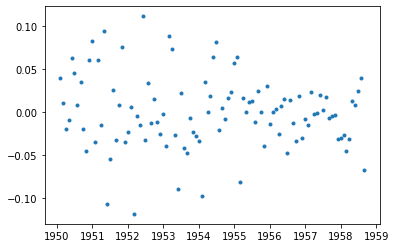

In [11]:
#weźmy model (3,0,3)  - to co wcześniej wywnioskowaliśmy z acf i pacf choć metoda AIC/BIC/MSE/MAE sugeruje inne
ar33 = ARIMA(endog = air_passengers_log_diff_12_train, order=(3,0,3))
ar33 = ar33.fit()
plt.plot(ar33.resid, '.') # powinny ukladac sie losowo wokół y = 0, wygląda ok
plt.show()

In [12]:
sm.stats.durbin_watson(ar33.resid) # zakładmy, że reszty nie sa skorelowane (bliska 2 jest nasza wartość)

2.084273612253798

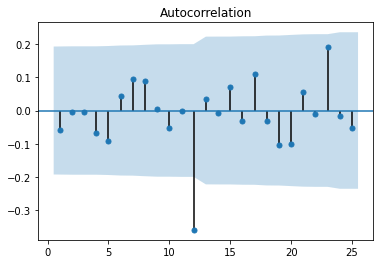

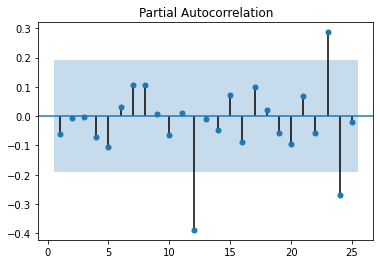

In [13]:
plot_acf(ar33.resid, lags=25, zero=False)
plt.show()

plot_pacf(ar33.resid, lags=25, zero=False)
plt.show()
#z grubsza ok

In [14]:
#normalność
stats.shapiro(ar33.resid)[1] #nawet normalne

0.10569006204605103

In [15]:
stats.normaltest(ar33.resid) #też

NormaltestResult(statistic=2.053887195189942, pvalue=0.35809978670953674)

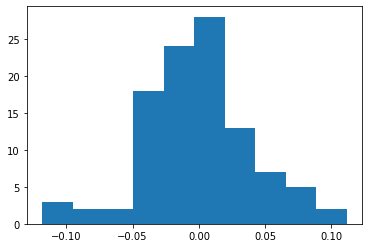

In [16]:
plt.hist(ar33.resid)
plt.show() #od biedy normalny

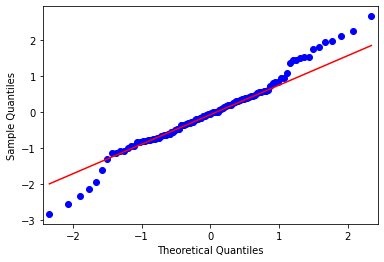

In [17]:
qqplot(ar33.resid, line='q', fit=True)
plt.show() #troszkę na ogonach może nie tak, ale z grubsza ok

In [18]:
#podzielmy zatem dane wejściowe na zbiór treningowy i testowy i dopasujmy model SARIMA
k = int(air_passengers.size * 0.8)

air_passengers_train = air_passengers[:k]
air_passengers_test = air_passengers[k:]

m2 = SARIMAX(endog=np.log(air_passengers_train), order=(3, 1, 3),seasonal_order = (0,1,0,12), trend='c').fit()
air_passengers_test

,#Passengers
Month,
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396


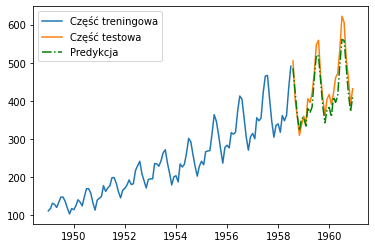

In [19]:
m2_pred = m2.predict(start='1958-08-01', end='1960-12-01', dynamic=True) #bardzo ładna predykcja robiona tylko samym modelem bez danych historycznych

plt.plot(air_passengers_train, label="Część treningowa")
plt.plot(air_passengers_test, label="Część testowa")
plt.plot(np.exp(m2_pred), 'g-.', label="Predykcja")
plt.legend()
plt.show()